# Lesson 1

## 1. Objectives

The main objective of this notebook is to replicate the results from the first lesson of Fast AI course (https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb).

I decided to do the following:
1. Create vgg16 model based on vgg16 class. It should be able to distinguish between cats and dogs.
2. Take part in the Dogs vs Cats Kaggle Competition
3. Create vgg16 model which works on some other dataset.

Data should be downloaded from http://files.fast.ai/data/dogscats.zip and put into data directory.

## 2. Setting up

In [2]:
%matplotlib inline
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [3]:
import utils; reload(utils)
from utils import plots

Using TensorFlow backend.
/Users/michalstechly/Documents/Fast_AI/fast-venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [ ]:
# path = os.path.join("..","data","dogscats")
path = os.path.join("..","data","dogscats","sample")

In [ ]:
batch_size = 64

## 3. VGG16 - cats and dogs

In [ ]:
network = Vgg16()

In [ ]:
train_batches = network.get_batches(os.path.join(path, "train"))
validation_batches = network.get_batches(os.path.join(path, "valid"))
network.finetune(train_batches)

In [ ]:
network.fit(train_batches, validation_batches)

In [ ]:
batches = network.get_batches(os.path.join(path,"train"), batch_size=4)

In [ ]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

## 4. Kaggle competition 

In [5]:
path = os.path.join("..","data","dogscats_kaggle", "sample")
# path = os.path.join("..","data","dogscats_kaggle")

To download the data follow the instructions: http://wiki.fast.ai/index.php/Kaggle_CLI and put the dat a to the dogscats_kaggle directory.

In [ ]:
import glob
import shutil

In [ ]:
def safe_mkdir(path):
    """
    Checks if a directory exists. If not, creates it.
    """
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        pass
    except AttributeError as exc:
        pass

Creating training and validation set.

Also, puts test data into a structure where we can use get_batches method easily.

In [ ]:
cats_train_path = os.path.join(path, "train_grouped", "cats")
cats_valid_path = os.path.join(path, "valid_grouped", "cats")
safe_mkdir(cats_train_path)
safe_mkdir(cats_valid_path)


dogs_train_path = os.path.join(path, "train_grouped", "dogs")
dogs_valid_path = os.path.join(path, "valid_grouped", "dogs")
safe_mkdir(dogs_train_path)
safe_mkdir(dogs_valid_path)

filenames = glob.glob(os.path.join(path, "train", "*"))

cats_counter = 0
dogs_counter = 0
for filename in filenames:
    name = filename.split("/")[-1]
    if "cat" in name:
        if cats_counter < 4:
            shutil.copy(filename, os.path.join(cats_train_path, name))
            cats_counter += 1
        else:
            shutil.copy(filename, os.path.join(cats_valid_path, name))
            cats_counter = 0
    if "dog" in name:
        if dogs_counter < 4:
            shutil.copy(filename, os.path.join(dogs_train_path, name))
            dogs_counter += 1
        else:
            shutil.copy(filename, os.path.join(dogs_valid_path, name))
            dogs_counter = 0



In [ ]:
filenames = glob.glob(os.path.join(path, "test", "*"))
for filename in filenames:
    name = filename.split("/")[-1]
    file_id = name.split('.')[0]
    test_path = os.path.join(path, "test", file_id)
    safe_mkdir(test_path)
    shutil.move(filename, os.path.join(test_path, name))

Creating and training the network

In [6]:
network = Vgg16()

In [7]:
train_batches = network.get_batches(os.path.join(path, "train_grouped"))
validation_batches = network.get_batches(os.path.join(path, "valid_grouped"))
network.finetune(train_batches)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [8]:
network.fit(train_batches, validation_batches)

Epoch 1/1
16/16 [==============================] - 59s - loss: 0.9562 - acc: 0.4375 - val_loss: 1.5005 - val_acc: 0.3750


Predicting on the test set

Found 12500 images belonging to 12500 classes.


/Users/michalstechly/Documents/Fast_AI/fast-venv/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

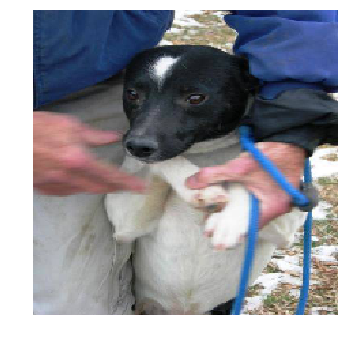

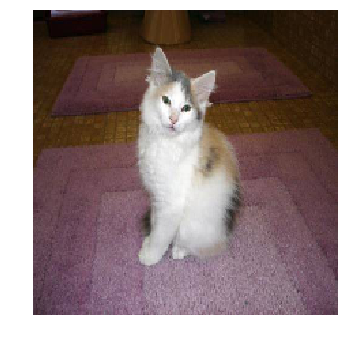

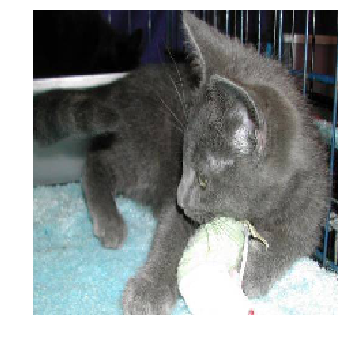

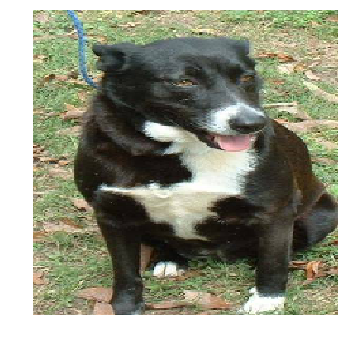

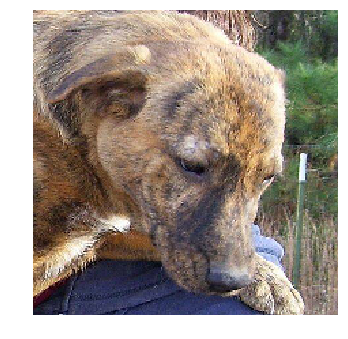

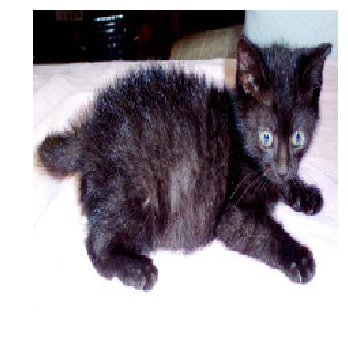

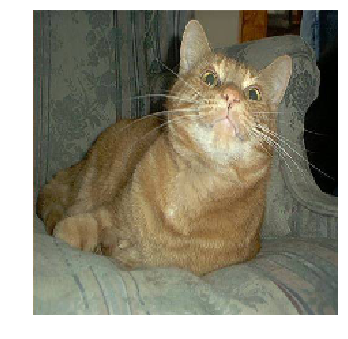

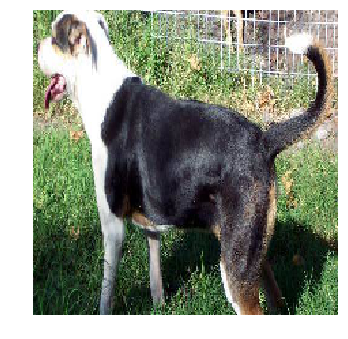

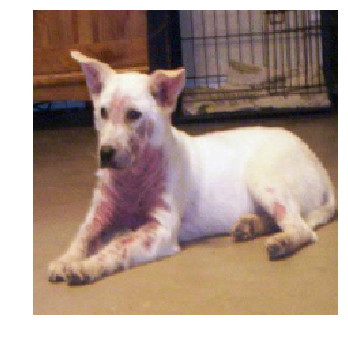

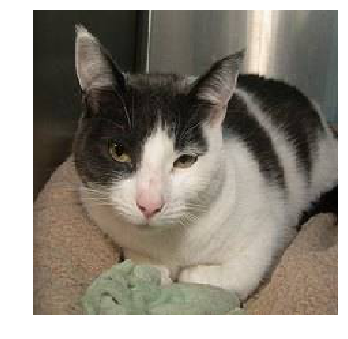

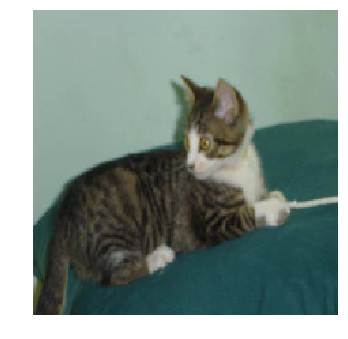

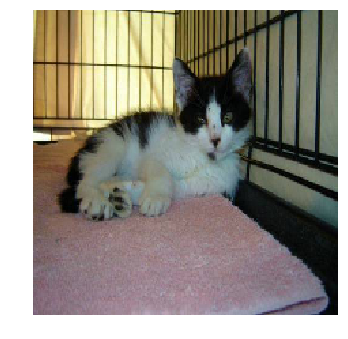

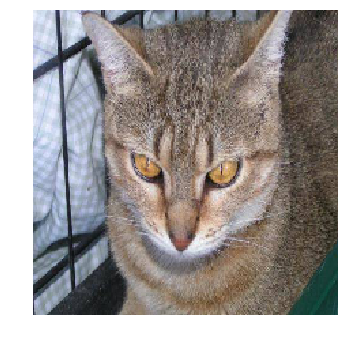

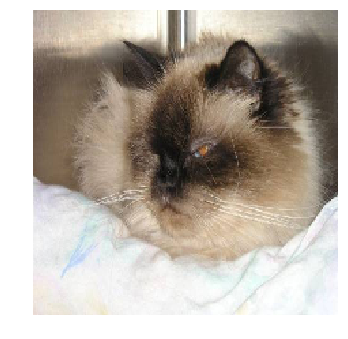

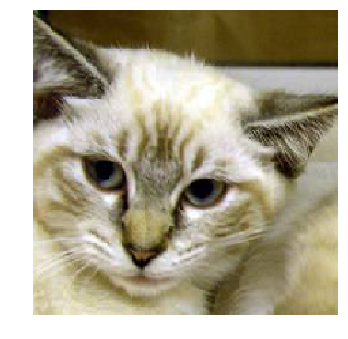

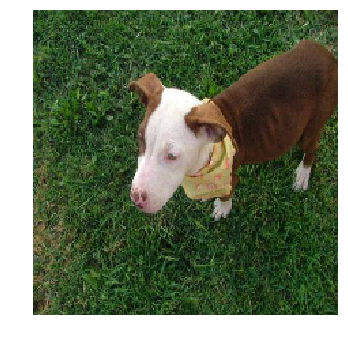

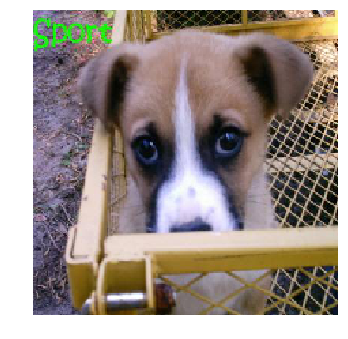

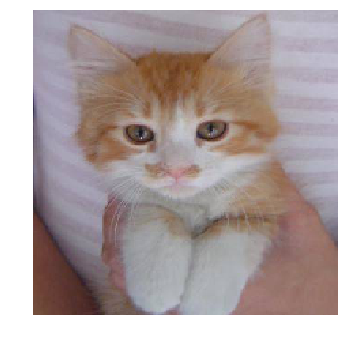

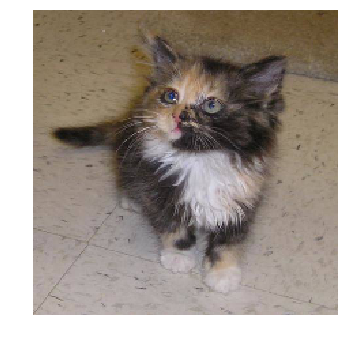

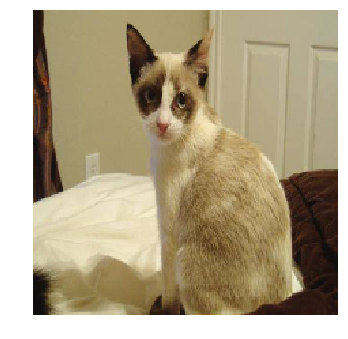

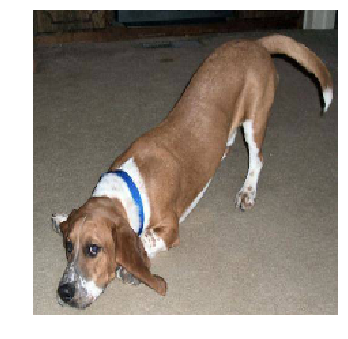

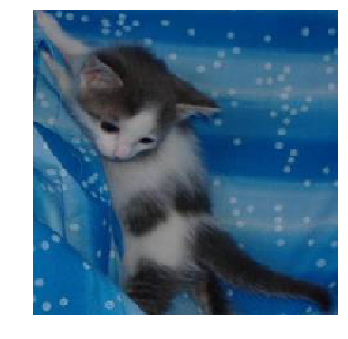

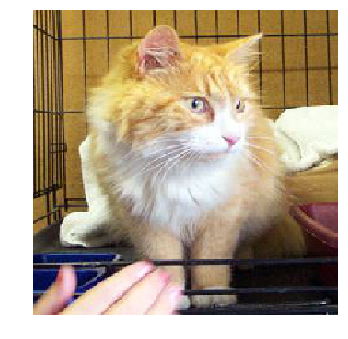

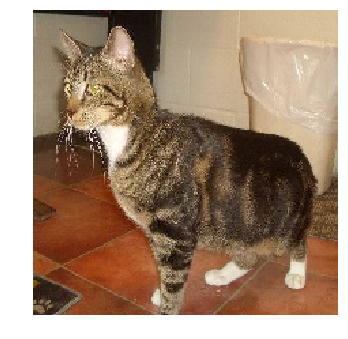

In [15]:
test_batch = network.get_batches(os.path.join(path, "test"), shuffle=False, batch_size=1)

with open('submission.csv', 'a') as the_file:
    the_file.write('id,label\n')


    for i in range(1, 12501):
        img, label = next(test_batch)
        prediction = network.predict(img)
        if prediction[1][0] == 0:
            probability = 1 - prediction[0][0]
        else:
            probability = prediction[0][0]
        image_id = np.where(label == 1)[1][0] + 1
        the_file.write(str(image_id))
        the_file.write(",")
        the_file.write(str(probability))
        the_file.write("\n")
        if i % 100 == 0:
            print(i)